In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time # for time cost
%matplotlib inline

In [2]:
data = pd.read_csv('./nba-shot-logs/shot_logs.csv')

In [3]:
data.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

In [4]:
label = [ 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST']
data_x = data[label].head(20000)


In [5]:
data_y = data['FGM'].head(20000)

In [6]:
data_x = (data_x - data_x.mean()) / data_x.std()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x,data_y,test_size=0.4, random_state=1)

In [8]:
#X_train = np.mat(X_train)
#y_train = np.mat(y_train).T
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],1)

In [9]:
y_train.shape

(12000, 1)

In [10]:
def unroll(A,B):  # A,B should be matrix form numpy array
    r1 = A.flatten(order='F')  # vectorization of matrix
    r2 = B.flatten(order='F')
    unrolled = np.vstack([r1.reshape(r1.shape[0],1), r2.reshape(r2.shape[0],1)])
    unrolled = unrolled.reshape(unrolled.shape[0])  # reshape into 1-dim array
    return unrolled


In [11]:
def roll_2(array,input_size, hidden_size, output_size):  # Roll back to the 2 matrices
    vec = array.reshape(array.shape[0],1)
    Theta1 = vec[:((input_size+1)*hidden_size),:].reshape(hidden_size,(input_size+1),order='F')
    Theta2 = vec[((input_size+1)*hidden_size):,:].reshape(output_size,(hidden_size+1),order='F')
    return Theta1,Theta2

In [12]:
input_size = 4
hidden_size = 2
output_size = 1

In [13]:
def sigmoid(t):
    return 1/(1+np.exp(-t))

In [14]:
def sigmoidGradient(t):
    return sigmoid(t) * (1-sigmoid(t))

In [15]:
def cost_NN(para, input_size, hidden_size, output_size, X, y, lambd = 0):
    [Theta1,Theta2] = roll_2(para,input_size, hidden_size, output_size)
    # Forward prop
    m = X.shape[0]
    a1 = np.hstack([np.ones([m,1]),X])
    z2 = np.dot(a1, Theta1.T)
    a2 = np.hstack([np.ones([m,1]),sigmoid(z2)])
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)
    #y_vec = np.eye(10)[(y-1).T[0]]
    
    #J = -sum(sum(y_vec * np.log(a3) + (1-y_vec)*np.log(1-a3))) / m
    J = (-np.dot(y.T , np.log(a3)) - (np.dot((1-y).T ,np.log(1-a3)))) / m
    regularization = sum(sum(Theta1[:,1:]**2)) + sum(sum(Theta2[:,1:]**2))
    J_reg = J + lambd/(2*m)*regularization
    
    # Backward prop
    delta3 = a3-y
    delta2 = np.dot(delta3,Theta2)[:,1:] * sigmoidGradient(z2)
    Delta1 = np.dot(delta2.T,a1)
    Delta2 = np.dot(delta3.T,a2)
    Theta1_grad = Delta1 / m + lambd * np.hstack([np.zeros([hidden_size,1]), Theta1[:,1:]]) / m
    Theta2_grad = Delta2 / m + lambd * np.hstack([np.zeros([output_size,1]), Theta2[:,1:]]) / m
    grad = unroll(Theta1_grad, Theta2_grad)
    return J_reg, grad  # grad is 1-dim array

In [16]:
def cost(p):  # p is a flat array
    return cost_NN(p, input_size, hidden_size, output_size, X_train, y_train, lambd)[0]

def grad_cost(p):
    return cost_NN(p, input_size, hidden_size, output_size, X_train, y_train, lambd)[1]

In [17]:
import scipy.optimize as opt

In [18]:
# Randomly initialize the weights to small values
def rand_initial_para(L_in, L_out, epsilon_init = 0.12):
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init  # Uniform distribution U(-eps,eps)
    return W

In [19]:
### Get initialized parameters
initial_Theta1 = rand_initial_para(input_size,hidden_size)
initial_Theta2 = rand_initial_para(hidden_size,output_size)
initial_para = unroll(initial_Theta1,initial_Theta2)
initial_p = initial_para    #.reshape(initial_para.shape[0])  # whether needed, depends

In [20]:
cost_NN(initial_p, input_size, hidden_size, output_size, X_train, y_train, lambd = 1)[1].shape

(13,)

In [21]:
%%time
lambd = 1
## Choose some optimizer to solve the optimization problem
res = opt.fmin_cg(f=cost,x0=initial_p,fprime=grad_cost,maxiter=5000)
res

Optimization terminated successfully.
         Current function value: 0.653348
         Iterations: 270
         Function evaluations: 760
         Gradient evaluations: 760
Wall time: 4.84 s


In [22]:
print(cost(initial_p))
print(cost(res))

[[0.69079235]]
[[0.65334834]]


In [23]:
def predict(Theta1, Theta2, X, y):
    a1 = np.hstack([np.ones([X.shape[0],1]),X])
    z2 = np.dot(a1, Theta1.T)
    a2 = np.hstack([np.ones([z2.shape[0],1]),sigmoid(z2)])
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)
    prediction = np.argmax(a3,axis=1)
    accuracy = np.mean(np.argmax(a3,axis=1)+1 == y.T)
    print('Accuracy:',accuracy)
    return prediction, accuracy

In [24]:
[trained_theta1,trained_theta2] = roll_2(res,input_size, hidden_size, output_size)
predict(trained_theta1,trained_theta2,X_test,y_test)

Accuracy: 0.456


(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 0.456)

In [25]:
data

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,...,18.4,2,missed,"Williams, Deron",101114,2.6,0,0,brian roberts,203148
6,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,7,4,10:15,14.5,11,...,20.7,2,missed,"Jack, Jarrett",101127,6.1,0,0,brian roberts,203148
7,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,8,4,8:00,3.4,3,...,3.5,2,made,"Plumlee, Mason",203486,2.1,1,2,brian roberts,203148
8,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,9,4,5:14,12.4,0,...,24.6,3,missed,"Morris, Darius",202721,7.3,0,0,brian roberts,203148
9,21400890,"MAR 03, 2015 - CHA vs. LAL",H,W,1,1,2,11:32,17.4,0,...,22.4,3,missed,"Ellington, Wayne",201961,19.8,0,0,brian roberts,203148


In [26]:
temp = data[7000:20000]


In [27]:
temp1 = temp[temp['FGM'] == 1]
temp2 = temp[temp['FGM'] == 0]

In [28]:
data.columns


Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

In [29]:
temp2['TOUCH_TIME'].min()

-7.4

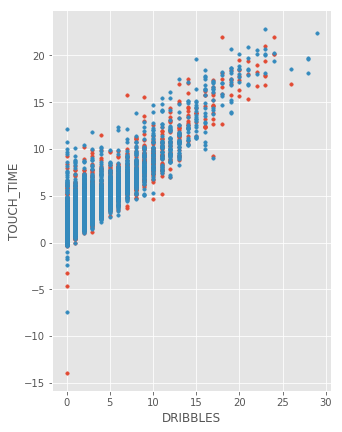

In [31]:
plt.figure(figsize=(5,7))
plt.style.use('ggplot')
plt.scatter(temp1['DRIBBLES'],temp1['TOUCH_TIME'],s = 12)
plt.scatter(temp2['DRIBBLES'],temp2['TOUCH_TIME'],s = 12)
plt.xlabel('DRIBBLES')
plt.ylabel('TOUCH_TIME')
plt.savefig('4.png')